First, we generate a random-simplicial complex.

In [292]:
import random
from typing import Dict
from smithnormalform import matrix, snfproblem, z
from itertools import combinations
import networkx as nx
import time
import matplotlib.pyplot as plt

In [274]:
def draw_graph(graph: Dict[int, list[int]]):
    nxg = nx.DiGraph()
    for vertex in graph[0]:
        nxg.add_node(vertex[0])
    for edge in graph[1]:
        nxg.add_edge(edge[0], edge[1])
    nx.draw_circular(nxg)

In [275]:
def generate_random_graph(vertex_count: int, edge_count: int) -> Dict[int, list[int]]:
    if edge_count > vertex_count * (vertex_count - 1) / 2:
        raise ValueError("More edges then possible.")
    graph = {0: [], 1: []}
    for vertex in range(vertex_count):
        graph[0].append([vertex])
    for _ in range(edge_count):
        edge = sorted(sum(random.sample(list(graph[0]), 2), []))
        while edge in graph[1]:
            edge = sorted(sum(random.sample(list(graph[0]), 2), []))
        graph[1].append(edge)
    return graph

def get_std_simplex_boundary(n: int) -> list[list[object]]:
    """
    Returns the boundary of the standard n-simplex (homotopy equivalent to S^{n-1}).
    """
    if n < 0:
        raise ValueError("n must be non-negative.")
    simp_comp = []
    for i in range(1, n + 1):
        simp_comp += [list(x) for x in combinations(list(range(1, n + 2)), i)]
    return simp_comp

def get_s_n(n: int) -> Dict[int, list[int]]:
    std_simplex = get_std_simplex_boundary(n+1)
    s_n = dict()
    for face in std_simplex:
        if len(face)-1 not in s_n:
            s_n[len(face)-1] = [face]
            continue
        s_n[len(face)-1].append(face)
    return s_n


In [276]:
def build_boundary_matrix(simplicial_complex: Dict[int, list[int]], dim: int) -> Dict[int, Dict[int, int]]:
    if dim == 0:
        raise ValueError("dim must be positive.")
    boundary_matrix = dict()
    for i in range(len(simplicial_complex[dim-1])):
        boundary_matrix[i] = dict()
        for j in range(len(simplicial_complex[dim])):
            boundary_matrix[i][j] = 0
    for i, simplex in enumerate(simplicial_complex[dim]):
        for j, vertex in enumerate(simplex):
            face = simplex[:j] + simplex[j+1:]
            face_id = simplicial_complex[dim-1].index(face)
            boundary_matrix[face_id][i] = (-1) ** j
    return boundary_matrix

def smith_normal_form(mat: Dict[int, list[int]]) -> Dict[int, list[int]]:
    row_count = len(mat)
    col_count = len(mat[0])
    matrix_list = []
    for row in range(row_count):
        for col in range(col_count):
            matrix_list.append(z.Z(mat[row][col]))
    original_matrix = matrix.Matrix(row_count, col_count, matrix_list)
    prob = snfproblem.SNFProblem(original_matrix)
    prob.computeSNF()
    if not prob.isValid():
        raise Exception("Smith normal form failed!")
    return_mat = dict()
    for i in range(row_count):
        return_mat[i] = dict()
    for i in range(row_count):
        for j in range(col_count):
            return_mat[i][j] = abs(prob.J.get(i, j).a)
    return return_mat

In [277]:
def get_homology_groups(simplicial_complex: Dict[int, list[int]]) -> list[list[int]]:
    images = [0]
    kernels = [len(simplicial_complex[0])]
    for dim in simplicial_complex:
        if dim == 0:
            continue
        boundary = build_boundary_matrix(simplicial_complex, dim)
        row_count = len(boundary)
        col_count = len(boundary[0])
        S = smith_normal_form(boundary)
        image = []
        for i in range(min(row_count, col_count)):
            if S[i][i] != 0:
                image.append(S[i][i])
        images.append(image)
        kernels.append(col_count - len(image))
    decompositions = []
    for dim in range(len(simplicial_complex)-1):
        decomposition = [kernels[dim] - len(images[dim+1])]
        for torsion in images[dim+1]:
            if torsion > 1:
                decomposition.append(torsion)
        decompositions.append(decomposition)
    decompositions.append([kernels[len(simplicial_complex)-1]])
    return decompositions

In [290]:

runs = []
n = 10
for i in range(5, 5+n):
    random.seed(69)
    rg = generate_random_graph(i, i+4)
    start = time.process_time()
    try:
        get_homology_groups(rg)
    except ZeroDivisionError:
        print(f"Run {i-4} failed by ZeroDivisionError (?).")
        continue
    time_taken = time.process_time() - start
    runs.append({
        "vertex_count": i,
        "edge_count": i+2,
        "time_taken": time_taken
    })
    print(f"Run {i-4} completed with {i} vertices and {i+4} edges in {time_taken} seconds.")

print(runs)

Run 1 completed with 5 vertices and 9 edges in 0.03125 seconds.
Run 2 completed with 6 vertices and 10 edges in 0.109375 seconds.
Run 3 completed with 7 vertices and 11 edges in 0.21875 seconds.
Run 4 completed with 8 vertices and 12 edges in 0.546875 seconds.
Run 5 completed with 9 vertices and 13 edges in 1.6875 seconds.
Run 6 completed with 10 vertices and 14 edges in 0.125 seconds.
Run 7 completed with 11 vertices and 15 edges in 0.171875 seconds.
Run 8 completed with 12 vertices and 16 edges in 13.09375 seconds.
Run 9 completed with 13 vertices and 17 edges in 33.28125 seconds.
Run 10 completed with 14 vertices and 18 edges in 70.578125 seconds.
[{'vertex_count': 5, 'edge_count': 7, 'time_taken': 0.03125}, {'vertex_count': 6, 'edge_count': 8, 'time_taken': 0.109375}, {'vertex_count': 7, 'edge_count': 9, 'time_taken': 0.21875}, {'vertex_count': 8, 'edge_count': 10, 'time_taken': 0.546875}, {'vertex_count': 9, 'edge_count': 11, 'time_taken': 1.6875}, {'vertex_count': 10, 'edge_count

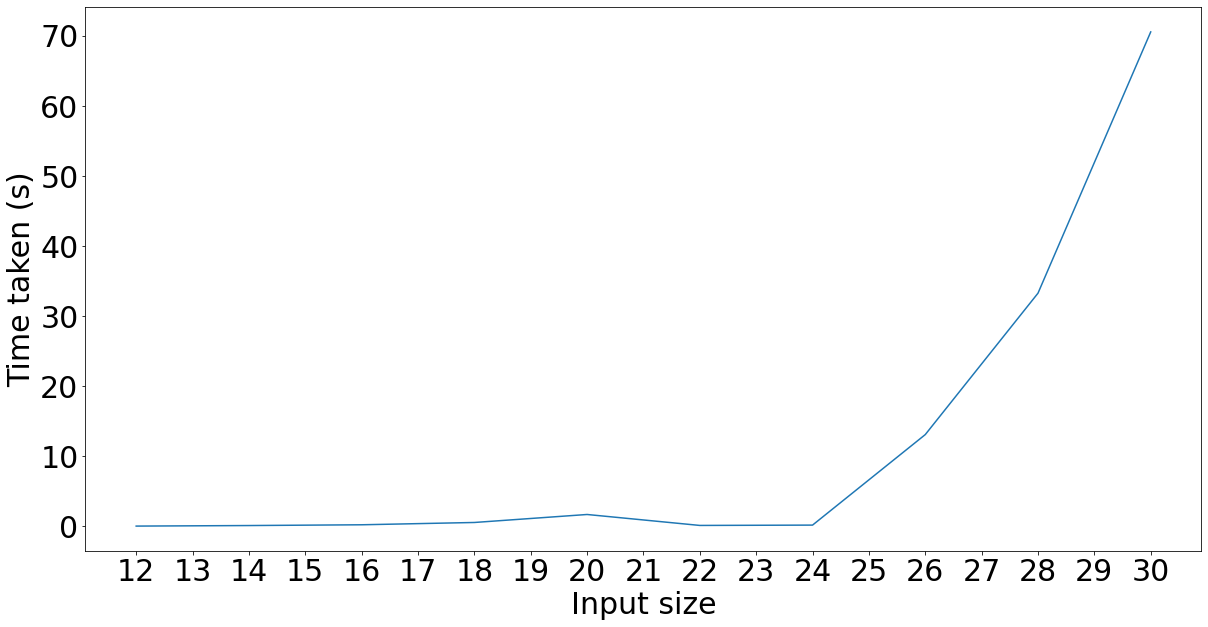

In [307]:
times = []
input_sizes = []

for run in runs:
    times.append(run["time_taken"])
    input_sizes.append(run["vertex_count"] + run["edge_count"])



Now we do the same for the persistent homology algorithm

In [312]:
def build_pers_simplices(vertex_count: int, edge_count: int) -> list[list[object]]:
    rg = generate_random_graph(vertex_count, edge_count)
    simplices = []
    for dim in rg:
        simplices += rg[dim]
    return simplices

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [2, 8], [1, 9], [2, 7], [7, 8], [8, 9], [1, 5], [6, 9], [4, 8], [7, 9], [0, 3]]


In [325]:
def is_empty_column(matrix: list[list[0, 1]], col: int) -> bool:
    for i in range(len(matrix)):
        if matrix[i][col] != 0:
            return False
    return True

def dimension(simplex: list[object]) -> int:
    return len(simplex) - 1


def simplices_to_boundary(simplices: list[list[object]]) -> list[list[0, 1]]:
    simplex_count = len(simplices)
    boundary = [[0 for i in range(simplex_count)] for i in range(simplex_count)]
    for i, simplex in enumerate(simplices):
        if dimension(simplex) == 0:
            continue
        for j, _ in enumerate(simplex):
            face = simplex.copy()
            face.pop(j)
            boundary[simplices.index(face)][i] = 1
    return boundary


def add_columns(mat: list[list[int]], col_in: int, col_out: int) -> None:
    for i in range(len(mat)):
        mat[i][col_out] = (mat[i][col_out] + mat[i][col_in]) % 2


def min_nonzero_in_column(mat: list[list[int]], col: int) -> int:
    """
    Returns the lowest row index of the non-zero entries in a column, in a given matrix. If the column is zero, then
    return -1.
    :param mat: the matrix.
    :param col: the column index.
    """
    for i in range(len(mat)):
        if mat[len(mat) - 1 - i][col] != 0:
            return len(mat) - 1 - i
    return -1


def standard_reduction(boundary: list[list[int]]) -> list[list[int]]:
    reduced_boundary = boundary.copy()
    low_dict = {}

    def is_col_reduced(col: int) -> (bool, int):
        if col == 0:
            return True, None
        min_nonzero = min_nonzero_in_column(reduced_boundary, col)
        if min_nonzero == -1:
            return True, None
        key = low_dict.get(min_nonzero)
        return key is None, key

    for i in range(len(boundary[0])):
        col_reduced = False
        while not col_reduced:
            col_reduced, j = is_col_reduced(i)
            if not col_reduced:
                add_columns(reduced_boundary, j, i)
        min_nonzero_new = min_nonzero_in_column(reduced_boundary, i)
        if min_nonzero_new != -1:
            low_dict[min_nonzero_new] = i

    return reduced_boundary

In [323]:
def read_homology_from_boundary(simplices: list[list[object]], reduced_boundary: list[list[0, 1]]) -> list[int]:
    zero_count = [0] * len(simplices[len(simplices) - 1])
    low_count = [0] * len(zero_count)
    for i, simplex in enumerate(simplices):
        if is_empty_column(reduced_boundary, i):
            zero_count[len(simplex) - 1] += 1
        min_nonzero = min_nonzero_in_column(reduced_boundary, i)
        if min_nonzero != -1:
            low_count[len(simplices[min_nonzero]) - 1] += 1
    homology_ranks = []
    for zero, low in zip(zero_count, low_count):
        homology_ranks.append(zero - low)
    return homology_ranks

In [376]:
runs2 = []
n = 50
for i in range(5, 5+n):
    random.seed(69)
    rg = build_pers_simplices(i, i+4)
    start = time.process_time()
    read_homology_from_boundary(rg, standard_reduction(simplices_to_boundary(rg)))
    time_taken = time.process_time() - start
    runs2.append({
        "vertex_count": i,
        "edge_count": i+2,
        "time_taken": time_taken
    })
    if i % 10 == 0:
        print(f"Run {i-4} completed with {i} vertices and {i+4} edges in {time_taken} seconds.")
times2 = []
input_sizes2 = []
for run in runs2:
    times2.append(run["time_taken"])
    input_sizes2.append(run["vertex_count"] + run["edge_count"])

14
16
18
20
22
24
Run 6 completed with 10 vertices and 14 edges in 0.0 seconds.
26
28
30
32
34
36
38
40
42
44
Run 16 completed with 20 vertices and 24 edges in 0.0 seconds.
46
48
50
52
54
56
58
60
62
64
Run 26 completed with 30 vertices and 34 edges in 0.0 seconds.
66
68
70
72
74
76
78
80
82
84
Run 36 completed with 40 vertices and 44 edges in 0.0 seconds.
86
88
90
92
94
96
98
100
102
104
Run 46 completed with 50 vertices and 54 edges in 0.015625 seconds.
106
108
110
112


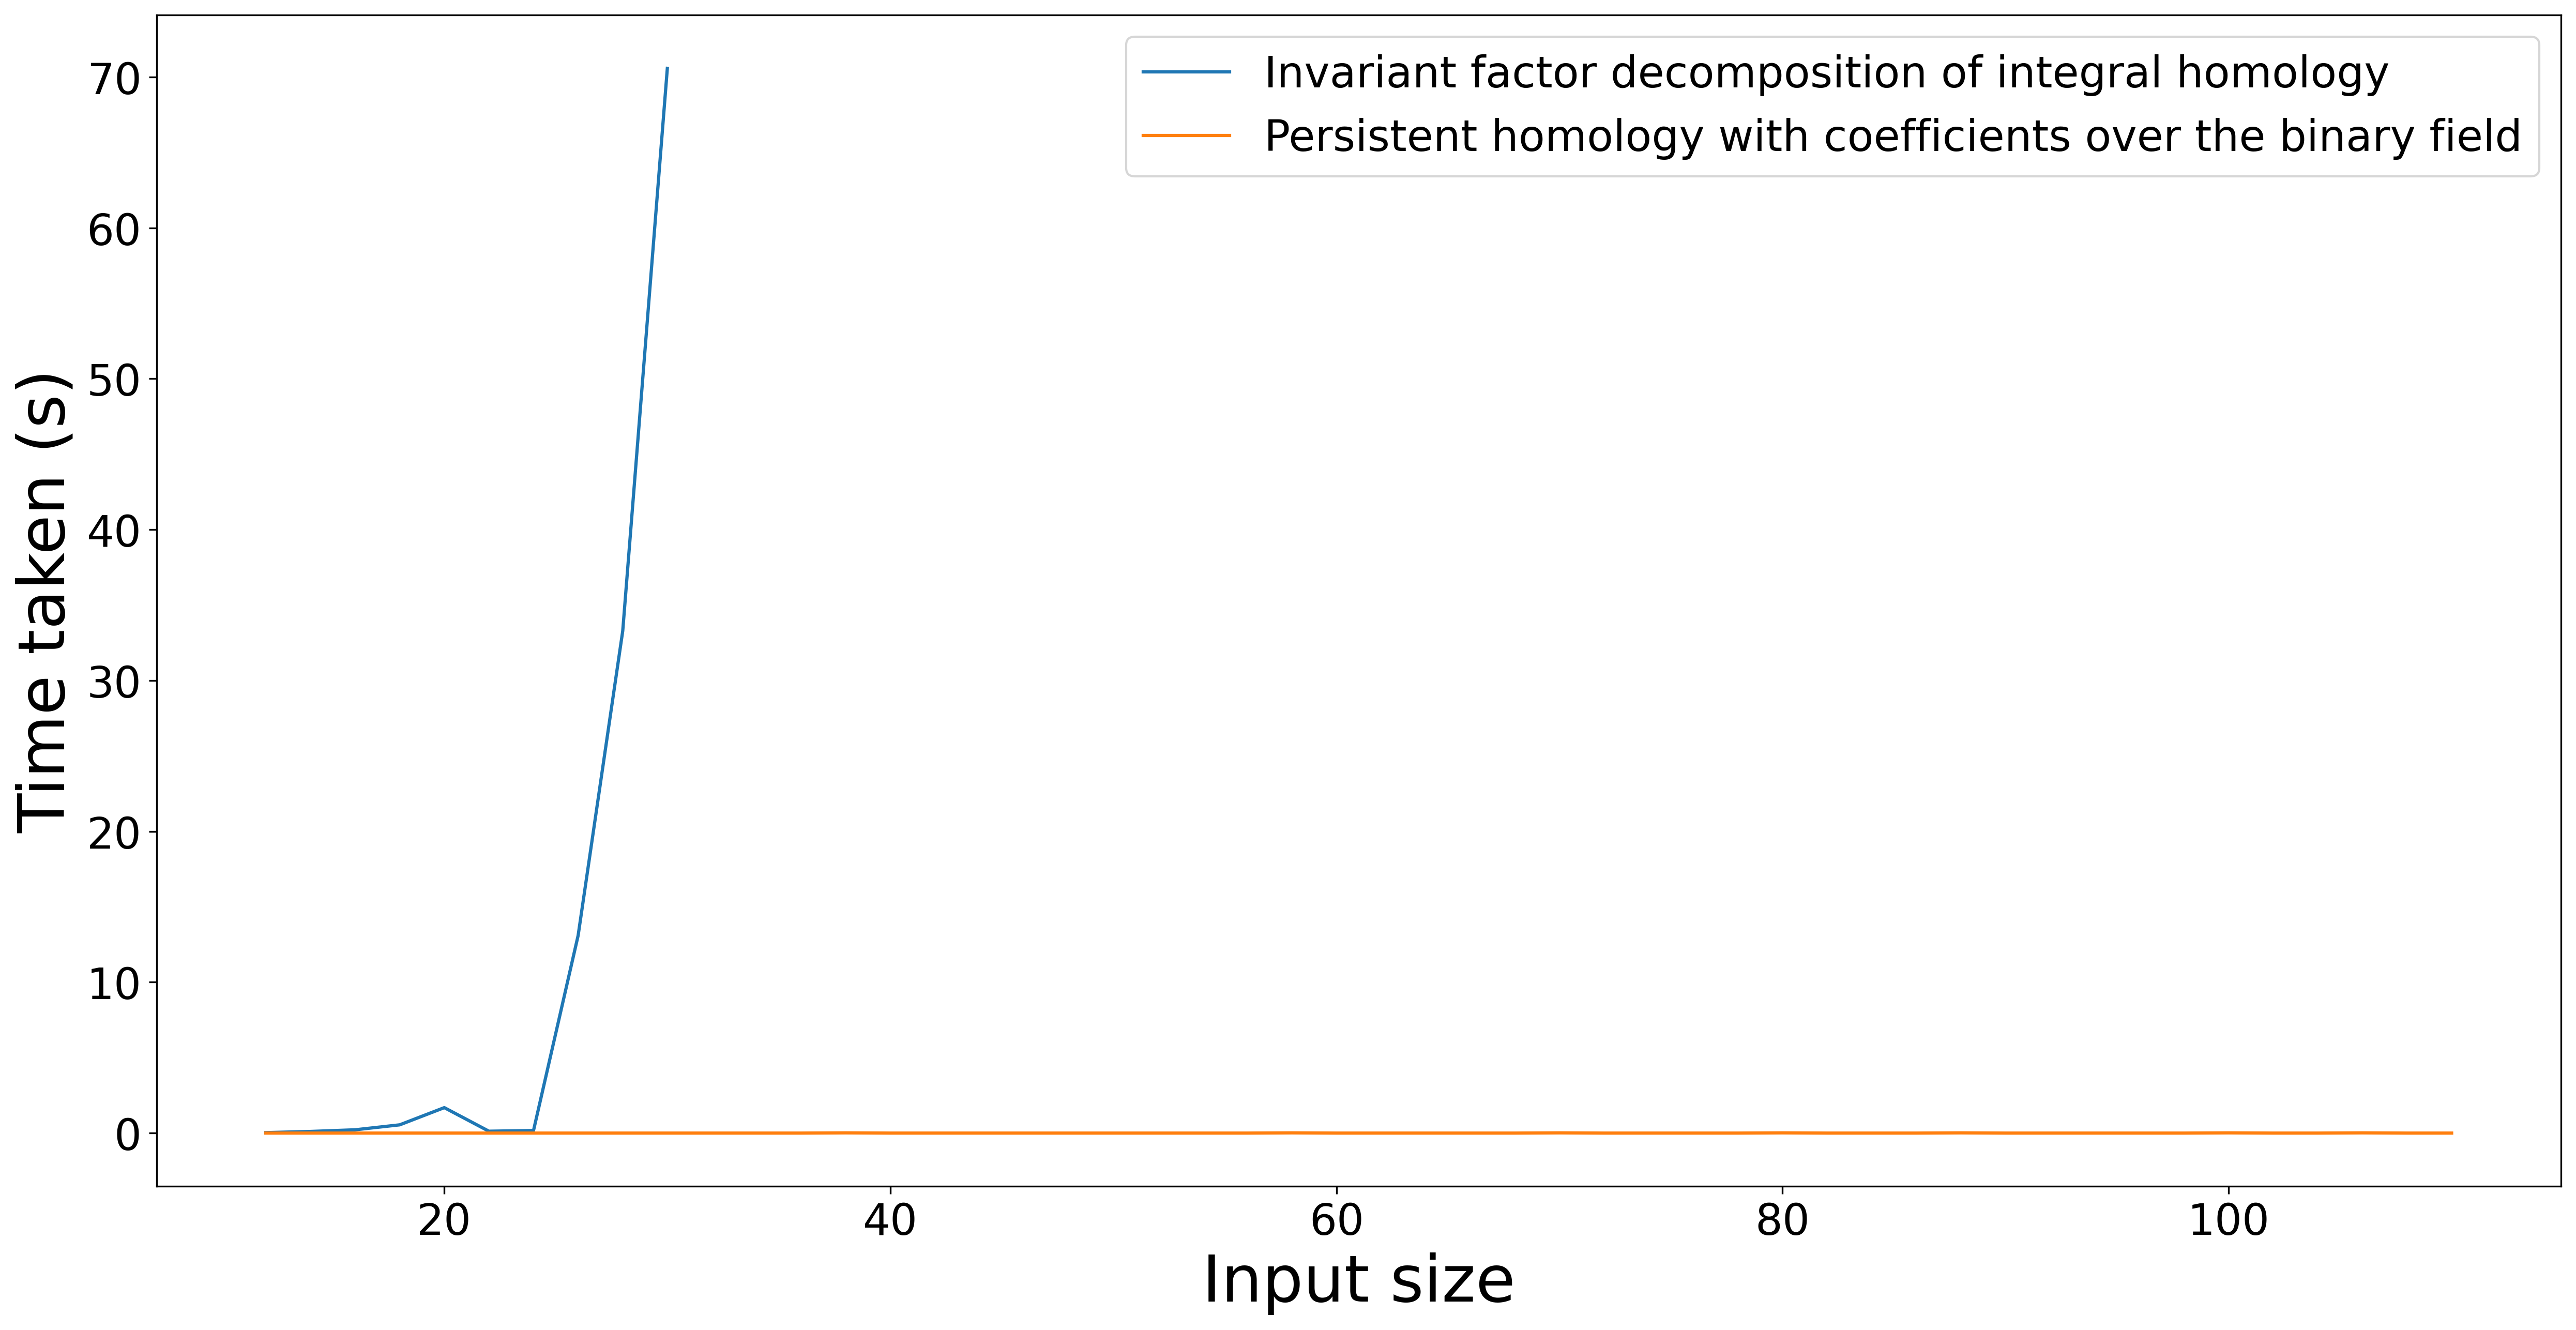

In [372]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['figure.dpi'] = 300
plt.xlabel("Input size", fontsize=30)
xint = range(min(input_sizes2), max(input_sizes2)+1)
plt.xticks(fontsize=20)
plt.ylabel("Time taken (s)", fontsize=30)
plt.yticks(fontsize=20)
plt.plot(input_sizes, times, label="Invariant factor decomposition of integral homology")
plt.plot(input_sizes2, times2, label="Persistent homology with coefficients over the binary field")
plt.legend(loc="best", prop={'size': 20})
plt.show()